# Clustering seal profiles and hydrographic sections using a Profile Classification Model (PCM; Maze et al., 2017)

### Import some libraries

In [1]:
import os,sys
import numpy as np
import netCDF4 as nc

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import interpolate

from datetime import datetime

# run clustering algorithms for T/S, using PCA as dimension reduction
from sklearn import preprocessing#, mixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

# import colormaps
from palettable.colorbrewer.qualitative import Accent_4 as acc
from palettable.colorbrewer.qualitative import Accent_5 as acc5
from palettable.colorbrewer.qualitative import Paired_4 as paired

from load_folders import fold_paths
fold_paths()

# import cm colorbars
sys.path.append(fold_paths.cmocean)
import cm

# import gsw library
sys.path.append(fold_paths.gsw)
import gsw

# import modules for PCM
sys.path.append(fold_paths.classification)
import run_PCM
import plot_maps

plotdir     = fold_paths.seals_plotdir
RTopo       = fold_paths.RTopo
sealdir     = fold_paths.folder_seals_raw
dirRdm      = fold_paths.dirRdm_seals
folder_seals= fold_paths.folder_seals

/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1078: UserWarning: Illegal line #1
	"$ cat ~/.matplotlib/matplotlibrc
"
	in file "/Users/Isa/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)


In [2]:
save_seals  = False
comp_rdm    = False
tt_split    = False

### Load bathymetry data (from RTopo) for the Amundsen Sea

In [3]:
data        = nc.Dataset(RTopo)

XC          = data.variables['lon'][:]
YC          = data.variables['lat'][:]
bathy       = data.variables['bedrock_topography'][:]
ice_topo    = data.variables['ice_base_topography'][:]
bathy       = np.ma.masked_greater(bathy,0.)
bathy       = -bathy
v           = np.linspace(0,6,7)
x1          = np.min(np.where(XC>=-110))
x2          = np.min(np.where(XC>=-99))
y1          = np.min(np.where(YC>=-75.5))
y2          = np.min(np.where(YC>=-70))
# labels for plotting
xtix      = np.linspace(-110,-99,6)
xtix_l    = ['%iW'%(np.abs(ii)) for ii in xtix]
ytix      = np.linspace(-75.5,-70,6)
ytix_l    = ['%iS'%(np.abs(ii)) for ii in ytix]

# new pressure array
press     = np.arange(2,1002,1)

bathy_data  = [XC,YC,bathy,x1,x2,y1,y2,xtix,xtix_l,ytix,ytix_l]

prop        = ['SA','TE']
axtit       = ['SA',r'$\theta$']
xlab        = ['PSU', '[$^{\circ}C$]']

## Run the PCM

### 1. Load Argo profiles

In [4]:
######################## TRAIN and PREDICT ARGO ########################
fileCTS   = os.path.join(folder_seals,'CT_dataSS.npz')
fileSAS   = os.path.join(folder_seals,'SA_dataSS.npz')
fileSPS   = os.path.join(folder_seals,'SP_dataSS.npz')
fileDDS   = os.path.join(folder_seals,'dens_dataSS.npz')
fileIDS   = os.path.join(folder_seals,'IDSS.npz')
fileLONS  = os.path.join(folder_seals,'lon_dataSS.npz')
fileLATS  = os.path.join(folder_seals,'lat_dataSS.npz')
fileYYS   = os.path.join(folder_seals,'years_dataSS.npz')
fileMMS   = os.path.join(folder_seals,'months_dataSS.npz')
if save_seals:
    # load the profiles     
    sys.path.append(fold_paths.classification)
    import load_profiles
    # if making some changes to the module, while running the kernel, reload the module:
    #import imp
    #imp.reload(load_profiles)

    # load the seal profiles
    [profSS, temporalSS] = load_profiles.load_seals(sealsdir,bathy_data)
    
    CT_dataSS  = profSS[0]
    SA_dataSS  = profSS[1]
    lon_dataSS = profSS[2]
    lat_dataSS = profSS[3]
    IDSS       = profSS[4]
    SP_dataSS  = profSS[5]
    # dates and seasons
    years_dataSS = temporalSS[0]
    months_dataSS= temporalSS[1]

    for ii in range(SP_dataSS.shape[0]):
        f0 = SP_dataSS[ii,:]
        f1 = f0[~np.isnan(f0)]
        if len(f1) == 0 and (len(idBad)==0 or idBad[-1]!=ii):
            idBad = np.append(idBad,ii)
        # check for empty temperature columns 
        f0 = CT_dataSS[ii,:]
        f1 = f0[~np.isnan(f0)]
        if len(f1) == 0 and (len(idBad)==0 or idBad[-1]!=ii):
            idBad = np.append(idBad,ii)	

    # delete the empty columns
    CT_dataSS  = np.delete(CT_dataSS,idBad,0)
    SA_dataSS  = np.delete(SA_dataSS,idBad,0)
    SP_dataSS  = np.delete(SP_dataSS,idBad,0)
    lon_dataSS = np.delete(lon_dataSS,idBad,0)
    lat_dataSS = np.delete(lat_dataSS,idBad,0)
    IDSS       = np.delete(IDSS,idBad,0)
    months_dataSS= np.delete(months_dataSS,idBad,0)
    years_dataSS = np.delete(years_dataSS,idBad,0)

    # after the cleaning above, there are 13938 profiles in total
    
    # chop between 10 m and 500 m.. more or less. There should be all numbers, and no Nans...
    # First search for those floats that have Nans Between 10 and 500 m
    id1,id2    = np.where(np.isnan(CT_dataSS[:,8:499]))

    # then, remove the floats where the first not NaN value is deeper than 10 or the deepest is shallower than 500 m
    idBadNew   = []
    for ii in np.unique(id1):
        if not(press[np.min(np.where(~np.isnan(CT_dataSS[ii,:])))]<=10. and press[np.max(np.where(~np.isnan(CT_dataSS[ii,:])))]>=500):
            idBadNew.append(ii)
    CT_dataSS  = np.delete(CT_dataSS,idBadNew,0)
    SA_dataSS  = np.delete(SA_dataSS,idBadNew,0)
    SP_dataSS  = np.delete(SP_dataSS,idBadNew,0)
    IDSS       = np.delete(IDSS,idBadNew,0)
    lon_dataSS = np.delete(lon_dataSS,idBadNew,0)
    lat_dataSS = np.delete(lat_dataSS,idBadNew,0)
    years_dataSS = np.delete(years_dataSS,idBadNew,0)
    months_dataSS= np.delete(months_dataSS,idBadNew,0)
    # after this cleaning there are only 4437 profiles left (i.e., 9501 removed): 
    #10 CT147 seals, 21 MEOP seals, 100 2019 CTDs and 12 2020 CTDs

    # sigma_theta (from Absolute Salinity and Conservative Temperature)
    dens_dataSS  = gsw.sigma0(SA_dataSS,CT_dataSS)

    # save compressed files:
    np.savez_compressed(fileCTS, CT_dataSS=CT_dataSS)
    np.savez_compressed(fileSAS, SA_dataSS=SA_dataSS)
    np.savez_compressed(fileSPS, SP_dataSS=SP_dataSS)
    np.savez_compressed(fileDDS, dens_dataSS=dens_dataSS)
    np.savez_compressed(fileIDS, IDSS=IDSS)
    np.savez_compressed(fileLONS, lon_dataSS=lon_dataSS)
    np.savez_compressed(fileLATS, lat_dataSS=lat_dataSS)
    np.savez_compressed(fileYYS,years_dataSS=years_dataSS)
    np.savez_compressed(fileMMS,months_dataSS=months_dataSS)
else:
    CT_dataSS  = np.load(fileCTS)['CT_dataSS']
    SA_dataSS  = np.load(fileSAS)['SA_dataSS']
    SP_dataSS  = np.load(fileSPS)['SP_dataSS']
    dens_dataSS= np.load(fileDDS)['dens_dataSS']
    IDSS       = np.load(fileIDS)['IDSS']
    lon_dataSS = np.load(fileLONS)['lon_dataSS']
    lat_dataSS = np.load(fileLATS)['lat_dataSS']
    years_dataSS  = np.load(fileYYS)['years_dataSS']
    months_dataSS = np.load(fileMMS)['months_dataSS']

### 2. Fit the scaler object between 10 and 500 m, in order to standardize dataset by removing the mean and scaling to unit variance:


In [5]:
idz1      = np.min(np.where(press>=10.))
idz2      = np.min(np.where(press>=500.))
scalerCT  = preprocessing.StandardScaler()
scalerCT  = scalerCT.fit(CT_dataSS[:,idz1:idz2])
scalerSA  = preprocessing.StandardScaler()
scalerSA  = scalerSA.fit(SA_dataSS[:,idz1:idz2])
scalerSP  = preprocessing.StandardScaler()
scalerSP  = scalerSP.fit(SP_dataSS[:,idz1:idz2])

# Mean and std profiles for the chopped profiles:
mean_CT   = scalerCT.mean_
std_CT    = scalerCT.scale_
mean_SA   = scalerSA.mean_
std_SA    = scalerSA.scale_
mean_SP   = scalerSP.mean_
std_SP    = scalerSP.scale_

# Normalize the chopped profiles
CTn       = scalerCT.transform(CT_dataSS[:,idz1:idz2])  
SAn       = scalerSA.transform(SA_dataSS[:,idz1:idz2])     
SPn       = scalerSA.transform(SP_dataSS[:,idz1:idz2])  

# take only the training set
if tt_split:
    # Can use the train_test_split() function, but this does not assure that we'll have a coherent distribution. 
    # better to randomly select a profile every 1degx1deg (see after)
    X       = PT_dataSO[:,100]
    y       = range(len(X))
    X_train, X_test, rdm, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rdm     = np.array(rdm)
else:
    # randomly select a profile every 0.1degx0.1deg
    outfileRdm = os.path.join(dirRdm,'random_89percent.npz')
    if comp_rdm:
        rdm = []
        degRdm = 0.1
        for ix in np.arange(XC[x1],XC[x2],degRdm):
            for iy in np.arange(YC[y1],YC[y2],degRdm):
                idx = np.where(np.logical_and(np.logical_and(np.logical_and(lon_dataSS>=ix,lon_dataSS<ix+degRdm),lat_dataSS>=iy),lat_dataSS<iy+degRdm))[0][:]
                try: 
                    tmp = np.random.choice(idx,1)
                    rdm = np.append(rdm,tmp)
                except:
                    print('no seals in %.1fE-%.1fE, %.1fS-%.1fS' %(ix,ix+degRdm,iy,iy+degRdm))

        rdm  = np.array([int(ii) for ii in rdm])
        np.savez(outfileRdm,rdm)
    else:
        npzfile = np.load(outfileRdm)
        rdm     = npzfile['arr_0']

CTn_tr  = CTn[rdm,:]
SAn_tr  = SAn[rdm,:]
SPn_tr  = SPn[rdm,:]  

# Extract mean and std of S and T of the whole profiles
mean_CT_t   = np.nanmean(CT_dataSS,axis=0)
std_CT_t    = np.nanstd(CT_dataSS,axis=0)
mean_SP_t   = np.nanmean(SP_dataSS,axis=0)
std_SP_t    = np.nanstd(SP_dataSS,axis=0)
mean_SA_t   = np.nanmean(SA_dataSS,axis=0)
std_SA_t    = np.nanstd(SA_dataSS,axis=0)

/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype >f4 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


### 3. Reduce the profiles using the PCA:

In [6]:
# get the training set
CTtr    = CT_dataSS[rdm,:]
SAtr    = SA_dataSS[rdm,:]
SPtr    = SP_dataSS[rdm,:]

# reduce the training set for the temperature
[Nc_CT,V_CT,EOFs_CT,EOFs_real_CT,CTtr_r,reducerCT] = run_PCM.compute_PCA(CTn_tr,scalerCT,None,1,'Conservative Temperature',press[idz1:idz2],plotdir,False)

The Variance Explained computed by me for all the components is  99.9053340114
The Variance Explained computed by me for the first 2 modes of the original data is  87.8741928948
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  6.50259709e-01   2.28468416e-01   7.14709327e-02   2.14571464e-02
   1.21997095e-02   5.27613620e-03   3.11168511e-03   2.15007802e-03
   1.30947240e-03   8.01147994e-04   6.71819899e-04   5.27743765e-04
   3.76652554e-04   3.28452155e-04   2.20752259e-04   1.65869777e-04
   1.37988594e-04   1.16931815e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 18 PCs



In [7]:
# reduce the training set for the salinity
[Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SAtr_r,reducerSA] = run_PCM.compute_PCA(SAn_tr,scalerSA,None,1,'Absolute Salinity',press[idz1:idz2],plotdir, False)

The Variance Explained computed by me for all the components is  99.909287554
The Variance Explained computed by me for the first 2 modes of the original data is  83.245566992
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  6.22316891e-01   2.08790431e-01   1.07173960e-01   3.21357738e-02
   1.29343259e-02   5.95446176e-03   4.10514194e-03   1.86536262e-03
   1.26345739e-03   7.77307756e-04   6.07319838e-04   4.19366388e-04
   3.33146327e-04   2.33708066e-04   1.70920657e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 15 PCs



In [8]:
# I don't want to print the output now:
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# reduce the full dataset:
[Nc_CT,V_CT,EOFs_CT,EOFs_real_CT,CT_r,reducerCT]   = run_PCM.compute_PCA(CTn,scalerCT,reducerCT,0,'Conservative Temperature',None,plotdir,False)
[Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SA_r,reducerSA]   = run_PCM.compute_PCA(SAn,scalerSA,reducerSA,0,'Absolute Salinity',None,plotdir,False)

# I can start to print out again:
sys.stdout = old_stdout

#### The variance explained by 3 components is >93.8% for both temperature and salinity. Reduce the original data using the first 3 modes for T and for S:

In [9]:
# 3 PCAs
# training set
setTr_r = np.zeros((CTtr_r.shape[0],6))
setTr_r[...,0] = CTtr_r[:,0]
setTr_r[...,1] = CTtr_r[:,1]
setTr_r[...,2] = CTtr_r[:,2]
setTr_r[...,3] = SAtr_r[:,0]
setTr_r[...,4] = SAtr_r[:,1]
setTr_r[...,5] = SAtr_r[:,2]
# full set
set_r = np.zeros((CT_r.shape[0],6))
set_r[...,0] = CT_r[:,0]
set_r[...,1] = CT_r[:,1]
set_r[...,2] = CT_r[:,2]
set_r[...,3] = SA_r[:,0]
set_r[...,4] = SA_r[:,1]
set_r[...,5] = SA_r[:,2]

#### How much does S add? Compute the cross correlation between the different modes (note: I think that it would be very helpful to check in different regions, because I think the cross correlation is higher in the ACC, where S doesn't add much to the method, but lower in the subtropics and close to Antarctica)

In [10]:
# I can start to print out again:
print 'cross correlation between PCA1_CT and PCA1_SA = ', np.corrcoef(CT_r[:,0],SA_r[:,0])[0,1]
print 'cross correlation between PCA1_CT and PCA2_SA = ', np.corrcoef(CT_r[:,0],SA_r[:,1])[0,1]
print 'cross correlation between PCA1_CT and PCA3_SA = ', np.corrcoef(CT_r[:,0],SA_r[:,2])[0,1]
print 'cross correlation between PCA2_CT and PCA1_SA = ', np.corrcoef(CT_r[:,1],SA_r[:,0])[0,1]
print 'cross correlation between PCA2_CT and PCA2_SA = ', np.corrcoef(CT_r[:,1],SA_r[:,1])[0,1]
print 'cross correlation between PCA2_CT and PCA3_SA = ', np.corrcoef(CT_r[:,1],SA_r[:,2])[0,1]
print 'cross correlation between PCA3_CT and PCA1_SA = ', np.corrcoef(CT_r[:,2],SA_r[:,0])[0,1]
print 'cross correlation between PCA3_CT and PCA2_SA = ', np.corrcoef(CT_r[:,2],SA_r[:,1])[0,1]
print 'cross correlation between PCA3_CT and PCA3_SA = ', np.corrcoef(CT_r[:,2],SA_r[:,2])[0,1]

cross correlation between PCA1_CT and PCA1_SA =  0.739735344397
cross correlation between PCA1_CT and PCA2_SA =  0.232116466359
cross correlation between PCA1_CT and PCA3_SA =  0.148841817124
cross correlation between PCA2_CT and PCA1_SA =  -0.368317094557
cross correlation between PCA2_CT and PCA2_SA =  -0.404440995808
cross correlation between PCA2_CT and PCA3_SA =  0.58962835391
cross correlation between PCA3_CT and PCA1_SA =  -0.0693634284367
cross correlation between PCA3_CT and PCA2_SA =  0.363906253344
cross correlation between PCA3_CT and PCA3_SA =  -0.00747386213233


### 4. Plot the Bayesian Information Criterion (BIC)

This criterion is used for model selection among a finite set of models. The model with the lowest BIC is chosen. Another selction criterion is the Akaike Information Criterion (AIC), which is not used here.

Compute the BIC score for the selected model and test it for a range of models 

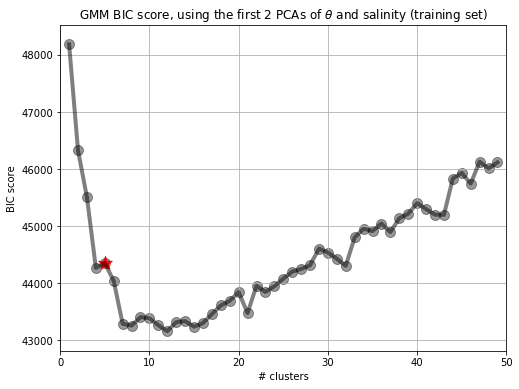

In [11]:
K = 5

# plot BIC score
run_PCM.plot_BIC(setTr_r,'T_S',K,plotdir)

### 5. Classify the profiles using the Gaussian Mixture Model (GMM) as classifier: extract the parameters, labels and probabilities

In [12]:
# run the gmm of the training set
[labels_tr,post_tr,gmm]    = run_PCM.run_gmm(setTr_r,'',1,K)
# Classify the dataset:
[labels,post,gmm]          = run_PCM.run_gmm(set_r,gmm,0,K)

### 6. Plot some maps

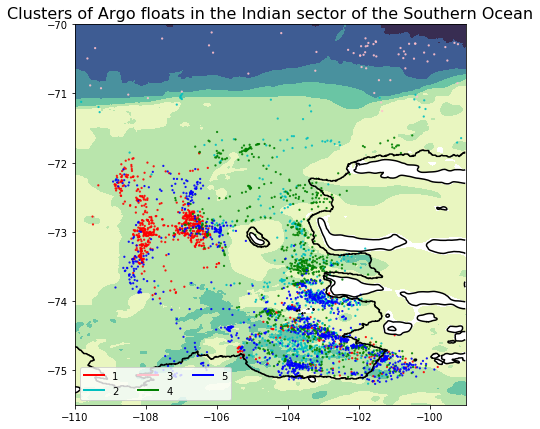

In [13]:
plot_maps.plot_clusters(labels,lon_dataSS,lat_dataSS,'T_S',K,bathy_data,plotdir)

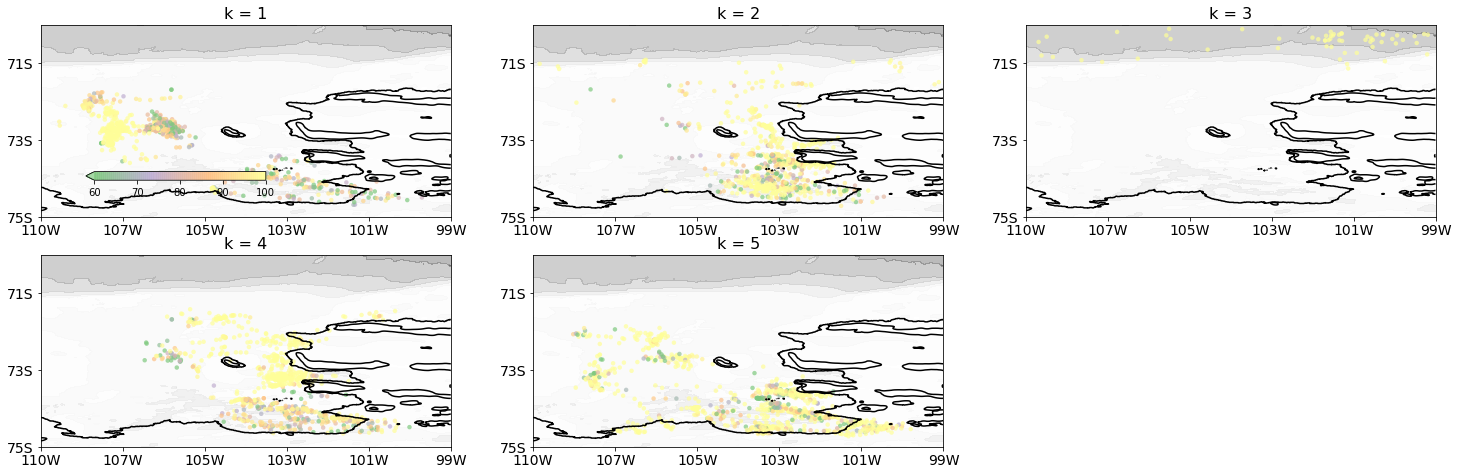

In [14]:
plot_maps.plot_map_prob(lon_dataSS,lat_dataSS,labels,post,K,bathy_data,'T_S',plotdir)

In [15]:
reload(plot_maps)

<module 'plot_maps' from 'plot_maps.pyc'>

### Plot the histograms of the probabilities

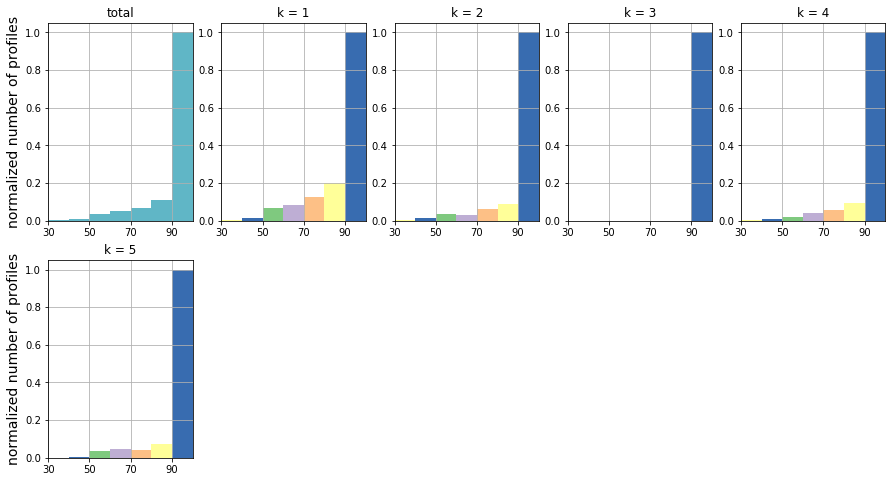

In [16]:
plot_maps.plot_histograms(labels,K,post,'T_S',plotdir)

### Plot the "fuzziness" 

GMM is a probabilistic of fuzzy classification, because it gives K posterior values for each profile, which add up to 1.

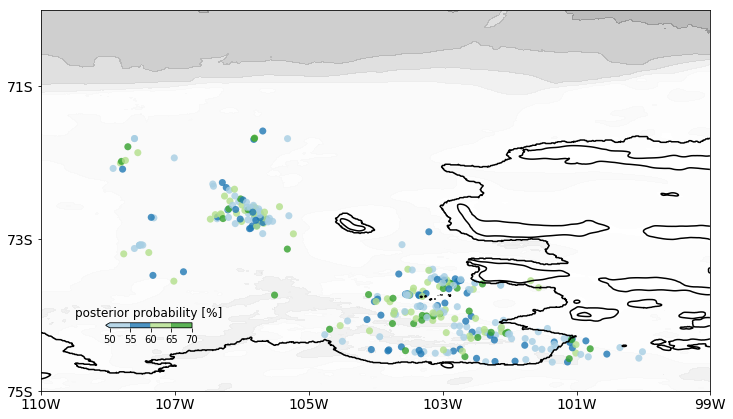

In [17]:
plot_maps.plot_fuzzy(K,lon_dataSS,lat_dataSS,labels,post,bathy_data,'T_S',plotdir)

## Repeat analysis for T and S combined: Q = [T S]

### Since we found that the cross-correlation between the 2 modes of T and S shows a not insignificant value, let's check what the combined field looks like

In [18]:
# combine T and S
Q       = np.zeros((CT_dataSS.shape[0],2*(idz2-idz1)),'>f4')
Q[:,:idz2-idz1] = CT_dataSS[:,idz1:idz2]
Q[:,idz2-idz1:] = SA_dataSS[:,idz1:idz2]

# normalize Q
scalerQ = preprocessing.StandardScaler()
scalerQ = scalerQ.fit(Q)
Qn      = scalerQ.transform(Q)

# extract training set using the rdm set defined before
Qn_tr   = Qn[rdm,:]
Qtr     = Q[rdm,:]

In [19]:
# build a new pressure array, with pressure levels repeated (since T and S are concatenated)
press2 = np.concatenate([press[idz1:idz2]]*2)
print 'The new pressure array has a dimension of',press2.shape[0]

# reduce the training set
[Nc_Q,V_Q,EOFs_Q,EOFs_real_Q,Qtr_r,reducerQ] = run_PCM.compute_PCA(Qn_tr,scalerQ,None,1,'Q = [T S]',press2,plotdir,True)
# reduce the full dataset:
[Nc_Q,V_Q,EOFs_Q,EOFs_real_Q,Q_r,reducerQ]   = run_PCM.compute_PCA(Qn,scalerQ,reducerQ,0,'Q = [T S]',press2,plotdir,True)

The new pressure array has a dimension of 980
The Variance Explained computed by me for all the components is  99.9024615119
The Variance Explained computed by me for the first 2 modes of the original data is  77.7183179613
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  5.90791268e-01   1.85567454e-01   1.10257591e-01   3.87590918e-02
   2.04967866e-02   1.64737819e-02   1.08445258e-02   7.70326350e-03
   4.30666065e-03   3.19310834e-03   2.16297884e-03   1.77142714e-03
   1.37973917e-03   1.04512901e-03   7.36468066e-04   6.33846676e-04
   5.00228194e-04   4.02212186e-04   3.58874180e-04   2.79287530e-04
   2.66456655e-04   2.15117568e-04   1.78651050e-04   1.60899015e-04
   1.39277962e-04   1.17072094e-04   1.03027371e-04   9.63636781e-05
   7.68123752e-05]

We reduced the dimensionality of the problem from 2000 depth levels down to 29 PCs

The Variance Explained computed by me for all the components is  99.8680569074
The Variance Explained

In [20]:
print 'The first 3 modes explain', [6.94726861e-01 + 2.71265084e-01 + 2.56593679e-02],'of the variance.'
print 'The first 4 modes explain', [6.94726861e-01 + 2.71265084e-01 + 2.56593679e-02 + 4.34414464e-03],'of the variance.'

The first 3 modes explain [0.9916513129000001] of the variance.
The first 4 modes explain [0.9959954575400001] of the variance.


### The first 3 PCAs of Q explain 99% of the variance. Let's work with these first!

In [21]:
# 3 PCAs
# training
setTrQ_r = Qtr_r[:,:3]
# full
setQ_r   = Q_r[:,:3]

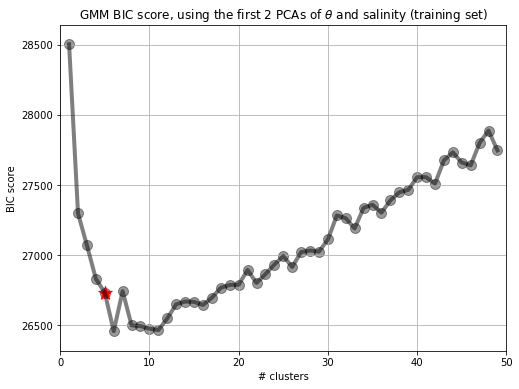

In [22]:
# plot the BIC
run_PCM.plot_BIC(setTrQ_r,'Q3',K,plotdir)

In [23]:
# run the gmm of the training set
[labels_Qtr,post_Qtr,gmmQ]    = run_PCM.run_gmm(setTrQ_r,'',1,K)
# Classify the dataset:
[labelsQ,postQ,gmmQ]          = run_PCM.run_gmm(setQ_r,gmmQ,0,K)

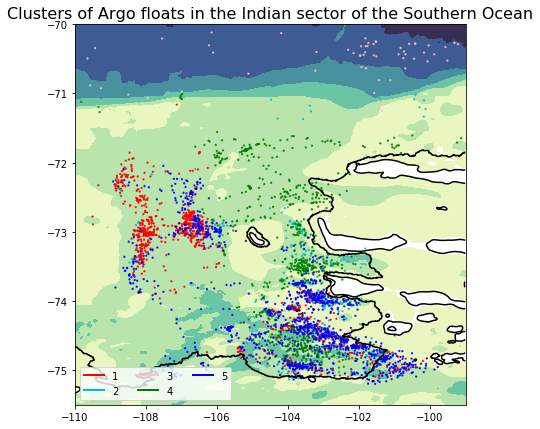

In [24]:
# plot the clusters
plot_maps.plot_clusters(labelsQ,lon_dataSS,lat_dataSS,'Q3',K,bathy_data,plotdir)

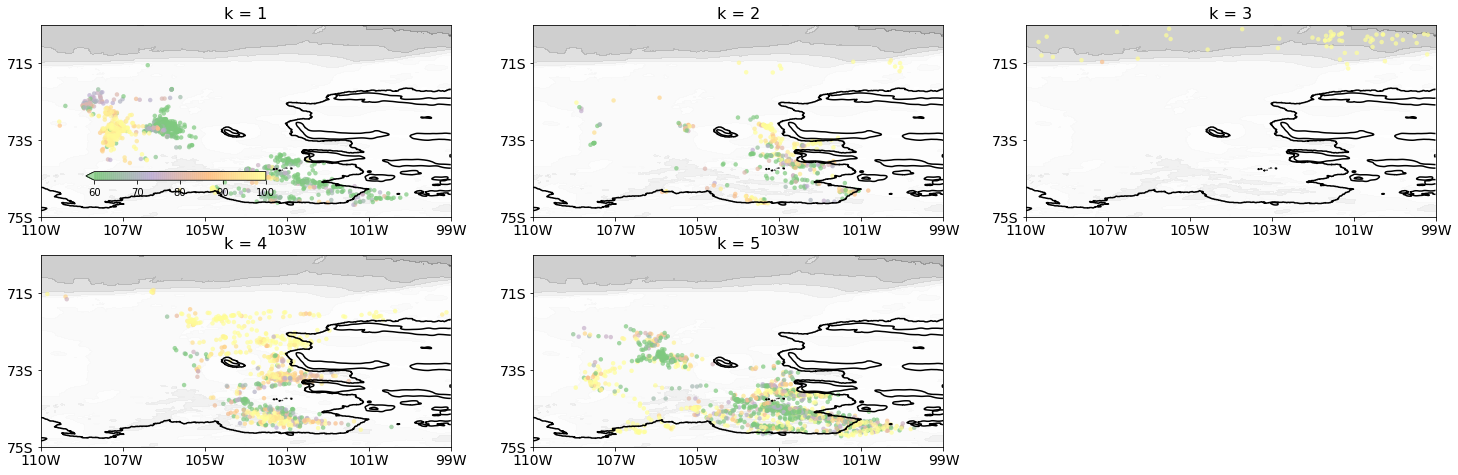

In [25]:
# map of clusters with post probab
plot_maps.plot_map_prob(lon_dataSS,lat_dataSS,labelsQ,postQ,K,bathy_data,'Q3',plotdir)

### The first 4 PCAs of Q explain 99.6% of the variance. Let's see what the result is with these modes..

In [26]:
# 4 PCAs
# training
setTrQ_r = Qtr_r[:,:4]
# full
setQ_r   = Q_r[:,:4]

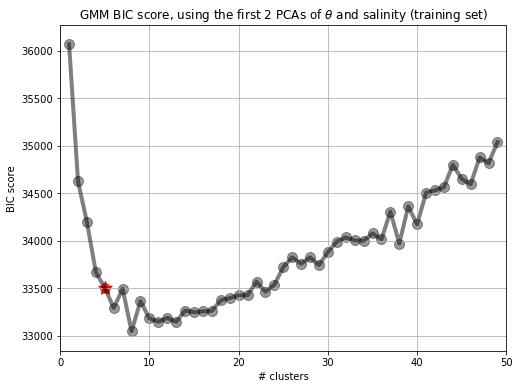

In [27]:
# plot the BIC
run_PCM.plot_BIC(setTrQ_r,'Q4',K,plotdir)

In [28]:
# run the gmm of the training set
[labels_Qtr,post_Qtr,gmmQ]    = run_PCM.run_gmm(setTrQ_r,'',1,K)
# Classify the dataset:
[labelsQ,postQ,gmmQ]          = run_PCM.run_gmm(setQ_r,gmmQ,0,K)

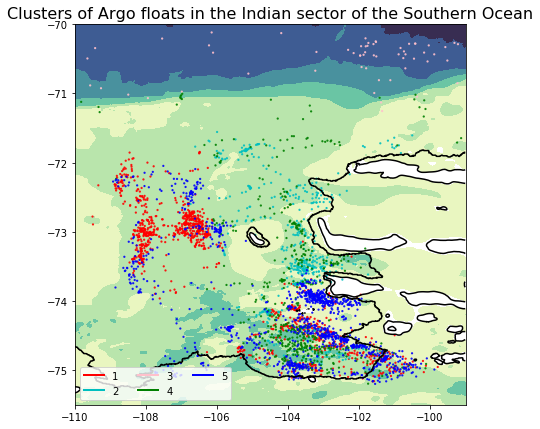

In [29]:
# plot the clusters
plot_maps.plot_clusters(labelsQ,lon_dataSS,lat_dataSS,'Q4',K,bathy_data,plotdir)

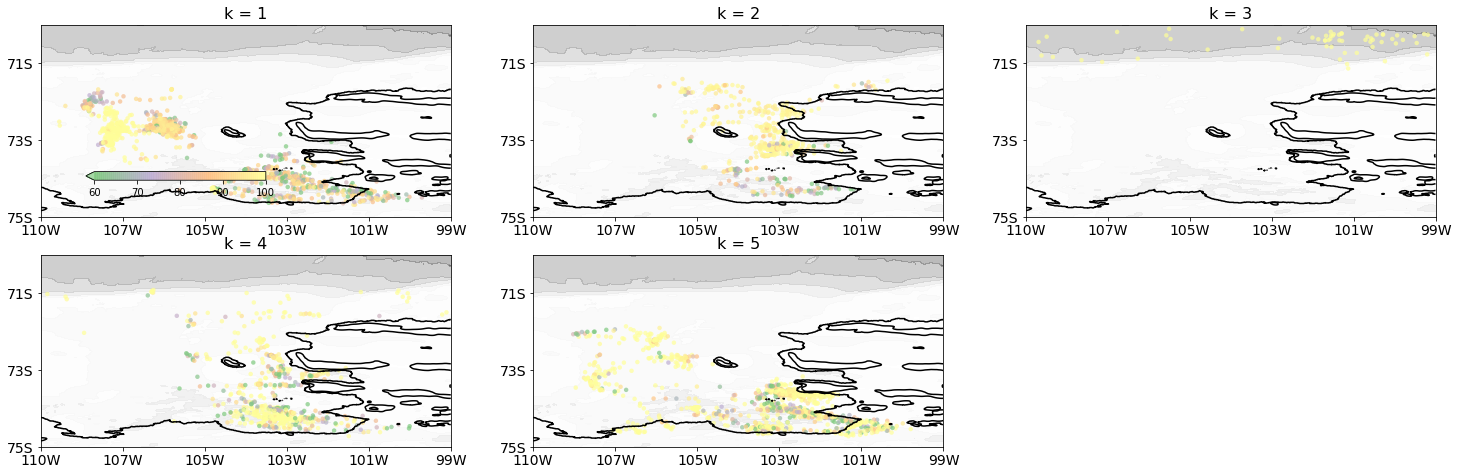

In [30]:
# map of clusters with post probab
plot_maps.plot_map_prob(lon_dataSS,lat_dataSS,labelsQ,postQ,K,bathy_data,'Q4',plotdir)